In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import numpy.ma as ma
import math
from math import radians, sin, cos, sqrt, atan2
import random
import powerlaw
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns
from geodatasets import get_path
from networkx.utils import powerlaw_sequence
import shapely
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, LineString
from scipy.spatial import ConvexHull
from shapely.ops import nearest_points
import shapely.ops as ops
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.special import factorial
from scipy.io import loadmat
from scipy.spatial import distance
from IPython.display import display
import itertools
import osmnx as ox
from geopy.distance import geodesic, great_circle
import pylab
import pyproj    
from functools import partial
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import rasterio
from shapely import make_valid
from tqdm import tqdm
from shapely.ops import unary_union

import warnings

# Ignora i warning
warnings.filterwarnings("ignore")

In [6]:
Bdf_path = 'data_BO/BolognaQuartieri_pois_2025-07-08.csv'
Bdf=pd.read_csv(Bdf_path)
gpd.options.display_precision = 16

Bgdf = gpd.GeoDataFrame(
    Bdf, geometry=gpd.points_from_xy(Bdf.longitude, Bdf.latitude), crs="EPSG:4326"
)
Bgdf=Bgdf.dropna(subset=['name']) 
Bgdf=Bgdf.dropna(subset=['fsq_category_labels']) 
Bgdf=Bgdf.loc[~Bgdf['date_closed'].notna(), :]

Bgdf['geo_count'] = Bgdf.groupby(['geometry'])['geometry'].transform('count')

Bgdfr=Bgdf[['fsq_place_id','fsq_category_labels','quartiere','geometry','latitude','longitude','name','geo_count']]

Bgdfr['geoname_count'] = Bgdfr.groupby(['geometry','name'])['name'].transform('count')
Bgdfr=Bgdfr[Bgdfr['geo_count']==Bgdfr['geoname_count']]
Bgdfr=Bgdfr[Bgdfr['geo_count']==1]

mask = Bgdfr['fsq_category_labels'].str.contains(r'\bLodging\b', case=False, na=False)
Bgdfr.loc[mask, 'fsq_category_labels'] = "['Lodging']"


Bgdfr['fsq_category_level1']=[i.replace("'",'"') for i in Bgdfr['fsq_category_labels']]
Bgdfr['fsq_category_level1']=[i.replace(', ',' > ') for i in Bgdfr['fsq_category_level1']]
#gdf['fsq_category_level1']=[i[i.index('["')+len('["'):i.index(">")] for i in gdf['fsq_category_level1']]
Bgdfr['fsq_category_level1']=[i[i.index('["')+len('["'):i.index(" > ") if ">" in i else len(i)-1] for i in Bgdfr['fsq_category_level1']]
Bgdfr['fsq_category_level1']=[i.replace('"','') for i in Bgdfr['fsq_category_level1']]

Bgdfr=Bgdfr[['fsq_place_id','fsq_category_labels','fsq_category_level1','quartiere','geometry','latitude','longitude','name','geo_count']]
Bgds = gpd.read_file('data_BO/aree-statistiche.geojson')
Bgdq = gpd.read_file('data_BO/quartieri-di-bologna.geojson')
Bgdz = gpd.read_file('data_BO/zone-del-comune-di-bologna.geojson')

Bgdfr = Bgdfr.to_crs(epsg=4326)
Bgds = Bgds.to_crs(epsg=4326)
#--------------------------------------------------------------------------- OSM

geojson_path = r"data_BO/poi_OSM_bologna_with_FS_tags.geojson"
gdf_osm = gpd.read_file(geojson_path)

# Creazione del campo pulito
def remove_after_first_arrow(s):
    if isinstance(s, str) and " > " in s:
        return s.split(" > ")[0]
    return s

gdf_osm["fsq_category_level1"] = gdf_osm["FS_path"].apply(remove_after_first_arrow)

# Anteprima
# Sostituzione diretta del valore nella colonna
# Dizionario con i valori vecchi e i nuovi
mapping = {
    'travel transportation': 'Travel and Transportation',
    'dining drinking': 'Dining and Drinking',
    'sports recreation': 'Sports and Recreation',
    'landmarks outdoors': 'Outdoors and Recreation',
    'community government':'Community and Government', 
    'arts entertainment':'Arts and Entertainment', 
    'retail':'Retail', 
    'business professional services':'Business and Professional Services',
    'health medicine':'Health and Medicine', 
    'event':'Event'
}

# Sostituzione multipla
gdf_osm['fsq_category_level1'] = gdf_osm['fsq_category_level1'].replace(mapping)

# Rimuovere i record senza categoria
gdf_osm = gdf_osm.dropna(subset=['fsq_category_level1']).reset_index(drop=True)
#-----------------------------------------------------
DIST_THRESHOLD_M = 10
CRS_METRIC = "EPSG:32632"  # UTM 32N (Bologna)
CRS_WGS84  = "EPSG:4326"

# ===============================
# 1) Prepara i due dataset con le colonne richieste
# ===============================
# Bgdfr: geometry, name, fsq_category_level1
bg = Bgdfr[['geometry', 'name', 'fsq_category_level1']].copy()

# gdf_osm: OSM_poi_name -> name, fsq_category_level1, geometry
osm = gdf_osm.rename(columns={'OSM_poi_name': 'name'})[['geometry', 'name', 'fsq_category_level1']].copy()

# ===============================
# 2) Normalizzazione nomi per il match
# ===============================
def norm_name(s):
    if pd.isna(s):
        return s
    # lower/casefold, strip, collassa spazi multipli
    return " ".join(str(s).casefold().strip().split())

bg['name_norm']  = bg['name'].apply(norm_name)
osm['name_norm'] = osm['name'].apply(norm_name)

# Assicura che siano GeoDataFrame con CRS
if not isinstance(bg, gpd.GeoDataFrame):
    bg = gpd.GeoDataFrame(bg, geometry='geometry')
if not isinstance(osm, gpd.GeoDataFrame):
    osm = gpd.GeoDataFrame(osm, geometry='geometry')

if bg.crs is None:
    bg.set_crs(CRS_WGS84, inplace=True)   # ipotesi: WGS84
if osm.crs is None:
    osm.set_crs(CRS_WGS84, inplace=True)  # ipotesi: WGS84

# ===============================
# 3) Proietta in metri
# ===============================
bg_m  = bg.to_crs(CRS_METRIC)
osm_m = osm.to_crs(CRS_METRIC)

# (opzionale) filtra geometrie non valide/null
bg_m  = bg_m[bg_m.geometry.notna() & bg_m.geometry.is_valid].copy()
osm_m = osm_m[osm_m.geometry.notna() & osm_m.geometry.is_valid].copy()

# ===============================
# 4) Join nearest: FS -> OSM (entro 10 m)  (how='left' per tenere tutti i FS)
# ===============================
j_bg = gpd.sjoin_nearest(
    bg_m, osm_m,
    how='left',
    max_distance=DIST_THRESHOLD_M,
    distance_col='dist_m',
    lsuffix='_fs', rsuffix='_osm'
)
# evita doppi underscore in alcune versioni
j_bg.columns = j_bg.columns.str.replace("__", "_", regex=False)

# Flag:
# - FS senza OSM entro 10 m => dist_m è NaN
bg_isolated_mask = j_bg['dist_m'].isna()

# - FS con OSM entro 10 m e stesso nome => teniamo solo FS
same_name_mask = j_bg['dist_m'].notna() & (j_bg['name_norm_fs'] == j_bg['name_norm_osm'])

# ===============================
# 5) Join nearest: OSM -> FS (entro 10 m)  (how='left' per tenere tutti gli OSM)
# ===============================
j_osm = gpd.sjoin_nearest(
    osm_m, bg_m,
    how='left',
    max_distance=DIST_THRESHOLD_M,
    distance_col='dist_m',
    lsuffix='_osm', rsuffix='_fs'
)
j_osm.columns = j_osm.columns.str.replace("__", "_", regex=False)

# OSM senza FS entro 10 m => dist_m è NaN
osm_isolated_mask = j_osm['dist_m'].isna()

# ===============================
# 6) Costruisci i tre insiemi secondo le regole
#    - distanza > 10 m: tieni tutti (FS isolati + OSM isolati)
#    - distanza ≤ 10 m e stesso nome: tieni solo FS
#    - distanza ≤ 10 m e nome diverso: scarta
# ===============================

# FS isolati (>10 m da qualunque OSM)
fs_keep_isolated = j_bg.loc[
    bg_isolated_mask,
    ['geometry', 'name_fs', 'fsq_category_level1_fs']
].copy()
fs_keep_isolated['source'] = 'fs'
fs_keep_isolated.rename(columns={
    'geometry': 'geometry',
    'name_fs': 'name',
    'fsq_category_level1_fs': 'fsq_category_level1'
}, inplace=True)

# FS con match entro 10m e stesso nome -> tieni solo FS (deduplica se stesso FS matcha più OSM)
fs_keep_matched_same_name = j_bg.loc[
    same_name_mask,
    ['geometry', 'name_fs', 'fsq_category_level1_fs']
].drop_duplicates().copy()
fs_keep_matched_same_name['source'] = 'fs'
fs_keep_matched_same_name.rename(columns={
    'geometry': 'geometry',
    'name_fs': 'name',
    'fsq_category_level1_fs': 'fsq_category_level1'
}, inplace=True)

# OSM isolati (>10 m da qualunque FS)
osm_keep_isolated = j_osm.loc[
    osm_isolated_mask,
    ['geometry', 'name_osm', 'fsq_category_level1_osm']
].copy()
osm_keep_isolated['source'] = 'osm'
osm_keep_isolated.rename(columns={
    'geometry': 'geometry',
    'name_osm': 'name',
    'fsq_category_level1_osm': 'fsq_category_level1'
}, inplace=True)

# ===============================
# 7) Unisci e riporta in WGS84
# ===============================
Bgdfr = pd.concat(
    [fs_keep_isolated, fs_keep_matched_same_name, osm_keep_isolated],
    ignore_index=True
)

Bgdfr = gpd.GeoDataFrame(Bgdfr, geometry='geometry', crs=CRS_METRIC).to_crs(CRS_WGS84)
Bgdfr = Bgdfr[['geometry', 'name', 'fsq_category_level1', 'source']].reset_index(drop=True)

# ===============================
# 8) (opzionale) Report rapido
# ===============================
print("FS isolati (>10m):", len(fs_keep_isolated))
print("FS tenuti per match entro 10m e stesso nome:", len(fs_keep_matched_same_name))
print("OSM isolati (>10m):", len(osm_keep_isolated))
print("Totale nel risultato finale:", len(Bgdfr))
#----------------------------- CANOPY PER 30
tif_path = r"data_BO/TreeCanopy_ExportV2.tif"
with rasterio.open(tif_path) as src:
    # Ottieni i dati del raster (prima banda, se il raster è multibanda)
    data = src.read(1)  # Leggi la prima banda del raster
    transform = src.transform  # Ottieni la matrice di trasformazione affine (per la georeferenziazione)
    crs = src.crs  # Sistema di riferimento spaziale (CRS)

    # Ottieni le dimensioni del raster
    rows, cols = np.where(data != src.nodata)  # Trova i pixel validi (non NODATA)

    # Crea le coordinate spaziali per ogni pixel
    points = [Point(transform * (col, row)) for row, col in zip(rows, cols)]  # Trasforma riga e colonna in coordinate spaziali

    # Ottieni i valori per ogni punto
    values = [data[row, col] for row, col in zip(rows, cols)]

    # Crea un GeoDataFrame con i punti e i valori dei pixel
    Bgdf_canopy = gpd.GeoDataFrame({'geometry': points, 'canopy_value': values}, crs=crs)
    
# Uniamo i dati di gdf e Bgds per evitare di fare il filtraggio ripetuto dentro il ciclo
Bgdf_cas = gpd.sjoin(Bgdf_canopy, Bgds, how="inner", predicate="within")

# Filtra i dati dove canopy_value è 0 o 1
Bgdf_cas_valid = Bgdf_cas[Bgdf_cas['canopy_value'].isin([0, 1])]

# Raggruppa per area_statistica_id e calcola la percentuale
results = Bgdf_cas_valid.groupby('codice_area_statistica').apply(
    lambda group: (group['canopy_value'].sum() / len(group)) * 100
).reset_index(name='perc_canopy_cover_30')

# Unisci i risultati nel GeoDataFrame delle aree statistiche (Bgds)
Bgds = Bgds.merge(results, left_on='codice_area_statistica', right_on='codice_area_statistica', how='left')
#--------------------------- TREE
Bgdf_tree=Bgdf_cas_valid[Bgdf_cas_valid['canopy_value']==1]
Bgdf_tree['tipo']='tree'
Bgdf_tree=Bgdf_tree[['geometry', 'quartiere', 'zona', 'area_statistica', 'codice_area_statistica', 'tipo']]

#----------------------------- PARCHI E GIARDINI PER 300
gdb_path = "data_BO/Bologna_dbsn.gdb"
# layers = fiona.listlayers(gdb_path)
#ar_vrd = gpd.read_file(gdb_path, layer="ar_vrd")
ar_vrd = gpd.read_file(gdb_path, layer="pe_uins")
ar_vrd=ar_vrd[ar_vrd['pe_uins_ty'].isin(['11','1101','1102','1103'])]
gdvt = gpd.GeoDataFrame(columns=['tipo', 'geometry'], geometry='geometry')
def merge_ar_vrd_into_gdvt(gdvt, ar_vrd):
    # Funzione per rimuovere Z dalle geometrie
    def remove_z(geom):
        if geom.geom_type == 'MultiPolygon':
            return MultiPolygon([Polygon([(x, y) for x, y, *_ in poly.exterior.coords]) for poly in geom.geoms])
        elif geom.geom_type == 'Polygon':
            return Polygon([(x, y) for x, y, *_ in geom.exterior.coords])
        return geom

    # Applica trasformazione e imposta tipo forest
    ar_vrd_clean = ar_vrd.copy()
    ar_vrd_clean['geometry'] = ar_vrd_clean['geometry'].apply(remove_z)
    
    #ar_vrd_clean['tipo'] = ar_vrd_clean['ar_vrd_ty'].apply(
    ar_vrd_clean['tipo'] = ar_vrd_clean['pe_uins_ty'].apply(
        lambda x: 'park or garden'
    )

    # Unione con gdvt
    return pd.concat([gdvt, ar_vrd_clean], ignore_index=True)
gdvt=merge_ar_vrd_into_gdvt(gdvt, ar_vrd)
gdvt = gdvt.to_crs(epsg=4326)
# Correggi eventuali geometrie non valide
Bgds['geometry'] = Bgds['geometry'].apply(make_valid)
gdvt['geometry'] = gdvt['geometry'].apply(make_valid)
sindex = gdvt.sindex
risultati = []
for idx, area_row in tqdm(Bgds.iterrows(), total=len(Bgds), desc="Elaborazione aree statistiche"):
    geom_area = area_row.geometry
    codice_area = area_row['codice_area_statistica']
    
    # Seleziona solo le geometrie verdi che intersecano l'area
    possibili_idx = list(sindex.intersection(geom_area.bounds))
    verde_in_zona = gdvt.iloc[possibili_idx]
    verde_in_zona = verde_in_zona[verde_in_zona.intersects(geom_area)]

    if verde_in_zona.empty:
        continue  # Nessuna intersezione, passa oltre

    # Esegui overlay solo sul subset
    try:
        overlay = gpd.overlay(
            verde_in_zona,
            gpd.GeoDataFrame([area_row], crs=Bgds.crs),
            how='intersection',
            keep_geom_type=False
        )
        risultati.append(overlay)
    except Exception as e:
        print(f"Errore nell'area {codice_area}: {e}")

# Unisci tutti i risultati
gdvt2 = gpd.GeoDataFrame(pd.concat(risultati, ignore_index=True), crs=Bgds.crs)

# Tieni solo i campi utili
gdvt2 = gdvt2[['geometry', 'quartiere', 'zona', 'area_statistica', 'codice_area_statistica', 'tipo']]
#------------------------------------------
gdvt3 = pd.concat([Bgdf_tree, gdvt2], axis=0, ignore_index=True)
#-------------------------------------------
# Effettua il join spaziale: per ogni punto trova il poligono che lo contiene
# 'how="left"' mantiene tutti i punti
# 'predicate="within"' indica che il punto deve essere contenuto nel poligono
Bgdfq = gpd.sjoin(
    Bgdfr,
    Bgds[['codice_area_statistica', 'area_statistica', 'quartiere', 'zona', 'geometry','perc_canopy_cover_30']],
    how='left',
    predicate='within'
)

Bgdfq=Bgdfq[['fsq_category_level1','geometry','name','quartiere','zona','area_statistica','codice_area_statistica','perc_canopy_cover_30','source']]

#--- popolazione per quartiere/zona e area statistica
# Carica il file JSON
df_pop = pd.read_json("data_BO/popolazione-residente-per-eta-sesso-cittadinanza-quartiere-zona-area-statistica-.json")
df_frag = pd.read_json("data_BO/indici-di-fragilita-dal-2021.json")
df_redd=pd.read_json("data_BO/redditi-per-area-statistica.json")
mapping_zona = {
    'San Ruffillo': 'S. Ruffillo',
    'San Vitale': 'S. Vitale',
    'Santa Viola': 'S. Viola'
   
}
df_pop['zona'] = df_pop['zona'].replace(mapping_zona)
df_frag['zona'] = df_frag['zona_pross'].replace(mapping_zona)

# Filtro per l'anno 2024
df_2024 = df_pop[df_pop['anno'] == 2024]
dfr_2023 = df_frag[df_frag['yyyy'] == 2023]
df_redd_2022 = df_redd[df_redd['anno_reddito'] == 2022]

# Raggruppa per codice area statistica e somma i residenti
Bdf_r_area = df_2024.groupby('codice_area_statistica')['residenti'].sum().reset_index()

# Raggruppa per codice area statistica e somma i residenti
Bdf_r_zona = df_2024.groupby('zona')['residenti'].sum().reset_index()

# Raggruppa per codice area statistica e somma i residenti
Bdf_r_quart = df_2024.groupby('quartiere')['residenti'].sum().reset_index()

# Merge tra quartieri e dati dei POI con residenti
Bgdfq_r = pd.merge(Bgdfq, Bdf_r_area, on='codice_area_statistica', how='inner')

# tolgo OSM dove non é compilato il nome
Bgdfq_r = Bgdfq_r[Bgdfq_r['name'].notna() & (Bgdfq_r['name'] != "")]

# Conteggio dei POI per categoria e area statistica
Bcounts_area = Bgdfq_r.groupby(['quartiere', 'codice_area_statistica', 'fsq_category_level1']).size().reset_index(name='count')

# Aggiungi residenti
Bcounts_area = pd.merge(Bcounts_area, Bdf_r_area[['codice_area_statistica', 'residenti']], on='codice_area_statistica', how='left')

# Calcola area delle geometrie
Bgds['area_km2'] = Bgds['geometry'].to_crs(epsg=3857).area / 1e6  # area in km²

Bcounts_area = pd.merge(Bcounts_area, Bgds[['codice_area_statistica', 'area_km2']], on='codice_area_statistica', how='left')

# Calcolo dei POI normalizzati in base allo scaling_mode
Bcounts_area['nPOI/res'] = Bcounts_area['count'] / Bcounts_area['residenti']
Bcounts_area['nPOI/area'] = Bcounts_area['count'] / Bcounts_area['area_km2']
Bcounts_area['nPOI/areares'] = Bcounts_area['count'] / (Bcounts_area['residenti'] * Bcounts_area['area_km2'])

# Crea colonna combinata
Bcounts_area['quartiere_area'] = Bcounts_area['quartiere'].astype(str) + ' - ' + Bcounts_area['codice_area_statistica'].astype(str)


FS isolati (>10m): 12816
FS tenuti per match entro 10m e stesso nome: 246
OSM isolati (>10m): 115474
Totale nel risultato finale: 128536


Elaborazione aree statistiche: 100%|████████████████████████████████████████████████████| 90/90 [00:00<00:00, 126.00it/s]


# 3-30-300 index

In [7]:
# Scarica edifici OSM
crs_usato = "EPSG:32632"

gdvt3 = gdvt3.to_crs(crs_usato)
Bgds = Bgds.to_crs(crs_usato)

bounding_polygon = Bgds.to_crs(epsg=4326).unary_union.convex_hull.buffer(0.01)
edifici_osm = ox.features_from_polygon(bounding_polygon, tags={"building": True})
edifici_osm = edifici_osm[edifici_osm['building'].isin(['residential', 'apartments', 'house', 'detached', 'yes'])]
edifici_osm = edifici_osm[['geometry']].explode(index_parts=False).reset_index(drop=True)
edifici_osm = edifici_osm.to_crs(crs_usato)
edifici_osm['geometry'] = edifici_osm['geometry'].apply(make_valid)

# Scarica strade OSM
strade_osm = ox.features_from_polygon(bounding_polygon, tags={"highway": True})
strade_osm = strade_osm[['geometry']].explode(index_parts=False).reset_index(drop=True)
strade_osm = strade_osm.to_crs(crs_usato)

# Precalcolo buffer e centroidi per ciascuna area
buffers_dict = {}
for codice in gdvt3['codice_area_statistica'].unique():
    verde_area = gdvt3[gdvt3['codice_area_statistica'] == codice]

    parks = verde_area[verde_area['tipo'] == 'park or garden']
    tree_forest = verde_area[verde_area['tipo'].isin(['tree'])]   # punti alberi

    buffer_parks = unary_union(parks.buffer(300).geometry) if not parks.empty else None

    # salvo anche i punti-albero per area, così posso contarli
    trees_gdf = tree_forest[['geometry']].copy() if not tree_forest.empty else None
    trees_sindex = trees_gdf.sindex if trees_gdf is not None else None  # indice spaziale

    buffers_dict[codice] = {
        'buffer_parks': buffer_parks,
        'trees_gdf': trees_gdf,
        'trees_sindex': trees_sindex
    }


def analizza_area(row_area, r_tree=50):
    """
    r_tree: raggio (metri) per cercare alberi dal centroide dell'edificio.
    Regola: incrementa 'edifici_vicini_tree_forest' se:
        - ci sono >= 3 alberi entro r_tree, OPPURE
        - l'edificio è vicino a un parco (come prima).
    """
    codice_area = row_area['codice_area_statistica']
    area_geom = row_area['geometry']

    edifici_area = edifici_osm[edifici_osm.geometry.intersects(area_geom)].copy()
    if edifici_area.empty:
        return codice_area, 0.0, 0.0, 0, 0

    numero_totale_edifici = len(edifici_area)
    edifici_vicini_parchi = 0
    edifici_vicini_tree_forest = 0

    bd = buffers_dict[codice_area]
    buffer_parks = bd['buffer_parks']
    trees_gdf = bd['trees_gdf']
    trees_sindex = bd['trees_sindex']

    for _, row in edifici_area.iterrows():
        edificio = row.geometry
        c = edificio.centroid

        # 1) vicino a parchi (come prima)
        vicino_parco = bool(buffer_parks and edificio.intersects(buffer_parks))
        if vicino_parco:
            edifici_vicini_parchi += 1

        # 2) almeno 3 alberi entro r_tree metri dal centroide
        ha_3_alberi = False
        if (trees_gdf is not None) and (trees_sindex is not None):
            # query preliminare coi bounds del buffer per efficienza
            candidates_idx = list(trees_sindex.intersection(c.buffer(r_tree).bounds))
            if candidates_idx:
                # distanza esatta punto-punto
                dists = trees_gdf.iloc[candidates_idx].geometry.distance(c)
                # conta i punti entro r_tree
                count_close = int(np.sum(dists <= r_tree))
                ha_3_alberi = (count_close >= 3)

        # regola OR: 3 alberi entro r_tree oppure parco
        if ha_3_alberi or vicino_parco:
            edifici_vicini_tree_forest += 1

    perc_parchi = (edifici_vicini_parchi / numero_totale_edifici) * 100 if numero_totale_edifici > 0 else 0.0
    perc_tree_forest = (edifici_vicini_tree_forest / numero_totale_edifici) * 100 if numero_totale_edifici > 0 else 0.0

    return codice_area, perc_parchi, perc_tree_forest, numero_totale_edifici, edifici_vicini_tree_forest

# Loop sulle aree
risultati = []
for idx, row in enumerate(Bgds.iterrows()):
    codice_area = row[1]['codice_area_statistica']
    area_label = row[1].get('area_statistica', '')
    print(f"Analizzando area: codice {codice_area}, nome: {area_label} ({idx+1}/{len(Bgds)})")
    result = analizza_area(row[1])
    #canopy_percent = row[1]['percentuale_canopy']
    print(f"Risultati per {result[0]}: % parchi {result[1]:.2f}, % tree/forest {result[2]:.2f}")#, % canopy {canopy_percent:.2f}")
    risultati.append(result)

# Salvataggio risultati
percentuali_df = pd.DataFrame(risultati, columns=['codice_area_statistica', 'perc_buildings_within_300m_park', 'perc_buildings_near_3_trees','num_buildings','num_buildings_near_3_trees'])

common_cols = [col for col in percentuali_df.columns if col in Bgds.columns and col != 'codice_area_statistica']
if common_cols:
    Bgds = Bgds.drop(columns=common_cols)
Bgds = Bgds.merge(percentuali_df, on='codice_area_statistica', how='left', suffixes=(None, '_new'))

for col in ['perc_buildings_within_300m_park', 'perc_buildings_near_3_trees']:
    if f"{col}_new" in Bgds.columns:
        Bgds[col] = Bgds[f"{col}_new"]
        Bgds = Bgds.drop(columns=[f"{col}_new"])



Analizzando area: codice 10, nome: RIGOSA (1/90)
Risultati per 10: % parchi 44.53, % tree/forest 100.00
Analizzando area: codice 29, nome: MARCONI-2 (2/90)
Risultati per 29: % parchi 69.45, % tree/forest 85.53
Analizzando area: codice 57, nome: SIEPELUNGA (3/90)
Risultati per 57: % parchi 83.56, % tree/forest 100.00
Analizzando area: codice 58, nome: DAGNINI (4/90)
Risultati per 58: % parchi 86.71, % tree/forest 99.35
Analizzando area: codice 77, nome: MALPIGHI-2 (5/90)
Risultati per 77: % parchi 29.22, % tree/forest 83.14
Analizzando area: codice 59, nome: CHIESANUOVA (6/90)
Risultati per 59: % parchi 22.88, % tree/forest 98.97
Analizzando area: codice 16, nome: EX MERCATO ORTOFRUTTICOLO (7/90)
Risultati per 16: % parchi 81.67, % tree/forest 86.67
Analizzando area: codice 2, nome: VIA DEL VIVAIO (8/90)
Risultati per 2: % parchi 0.00, % tree/forest 100.00
Analizzando area: codice 72, nome: XXI APRILE (9/90)
Risultati per 72: % parchi 17.91, % tree/forest 91.13
Analizzando area: codice 

In [8]:
# Conteggio condizioni superate
soglia_parchi = 100
soglia_tree_forest = 100
soglia_canopy = 30

def conta_condizioni(row):
    count = 0
    if row['perc_buildings_within_300m_park'] >= soglia_parchi:
        count += 1
    if row['perc_buildings_near_3_trees'] >= soglia_tree_forest:
        count += 1
    if row['perc_canopy_cover_30'] >= soglia_canopy:
        count += 1
    return count

def sup_park(row):
    count = 0
    if row['perc_buildings_within_300m_park'] >= soglia_parchi:
        count += 1
    return count
def sup_tree(row):
    count = 0
    if row['perc_buildings_near_3_trees'] >= soglia_tree_forest:
        count += 1
    return count
def sup_can(row):
    count = 0
    if row['perc_canopy_cover_30'] >= soglia_canopy:
        count += 1
    return count
# Calcolo e forzo nel range 0..3 (per sicurezza)
Bgds['num_conditions_met'] = Bgds.apply(conta_condizioni, axis=1).clip(0, 3)
Bgds['meet_3'] = Bgds.apply(sup_tree, axis=1).clip(0, 1)
Bgds['meet_30'] = Bgds.apply(sup_can, axis=1).clip(0, 1)
Bgds['meet_300'] = Bgds.apply(sup_park, axis=1).clip(0, 1)


In [11]:
d_eng = Bgds[['codice_area_statistica','area_statistica','geometry',
                'perc_buildings_near_3_trees', 'perc_canopy_cover_30', 'perc_buildings_within_300m_park',
                'num_conditions_met', 'meet_3', 'meet_30', 'meet_300']].copy()

rename_map = {
    'codice_area_statistica': 'stat_area_id',
    'area_statistica': 'stat_area_name'
    }

d_eng = d_eng.rename(columns=rename_map).copy()

cols_order = [
    'stat_area_id', 'stat_area_name', 'geometry',
    'perc_buildings_near_3_trees', 'perc_canopy_cover_30', 'perc_buildings_within_300m_park',
    'num_conditions_met', 'meet_3', 'meet_30', 'meet_300'
]
d_eng = d_eng[cols_order]

# for c in ['meet_3', 'meet_30', 'meet_300']:
#     if c in d_eng.columns:
#         d_eng[c] = d_eng[c].astype(bool)

# Salva il CSV pronto per l’upload su GitHub
d_eng.to_csv('bologna_3_30_300_stat_areas.csv', index=False)
print("Salvato: bologna_3_30_300_stat_areas.csv")
d_eng


Salvato: bologna_3_30_300_stat_areas.csv


,stat_area_id,stat_area_name,geometry,perc_buildings_near_3_trees,perc_canopy_cover_30,perc_buildings_within_300m_park,num_conditions_met,meet_3,meet_30,meet_300
0,10,RIGOSA,"POLYGON ((679852.7179985462 4932788.043119228,...",100.000000,75.979263,44.534413,2,1,1,0
1,29,MARCONI-2,"POLYGON ((686211.4129984963 4929965.924119201,...",85.528331,13.021297,69.448698,0,0,0,0
2,57,SIEPELUNGA,"POLYGON ((688006.2219984827 4927886.239119182,...",100.000000,49.953445,83.561644,2,1,1,0
3,58,DAGNINI,"POLYGON ((688984.1679984748 4927856.284119182,...",99.351702,33.684452,86.709887,1,0,1,0
4,77,MALPIGHI-2,"POLYGON ((685052.0569985057 4929940.198119203,...",83.138564,17.482001,29.215359,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
85,49,VIA MONDO,"POLYGON ((688673.7719984761 4930341.741119204,...",99.640288,33.935644,62.410072,1,0,1,0
86,46,SCALO MERCI SAN DONATO,"POLYGON ((693192.8349984392 4931493.648119212,...",95.061728,38.223485,0.000000,1,0,1,0
87,22,LA DOZZA,"POLYGON ((688068.0269984796 4933288.60611923, ...",100.000000,45.069411,100.000000,3,1,1,1
88,60,IRNERIO-1,"POLYGON ((686848.5869984913 4929662.482119197,...",68.847926,1.688252,63.870968,0,0,0,0


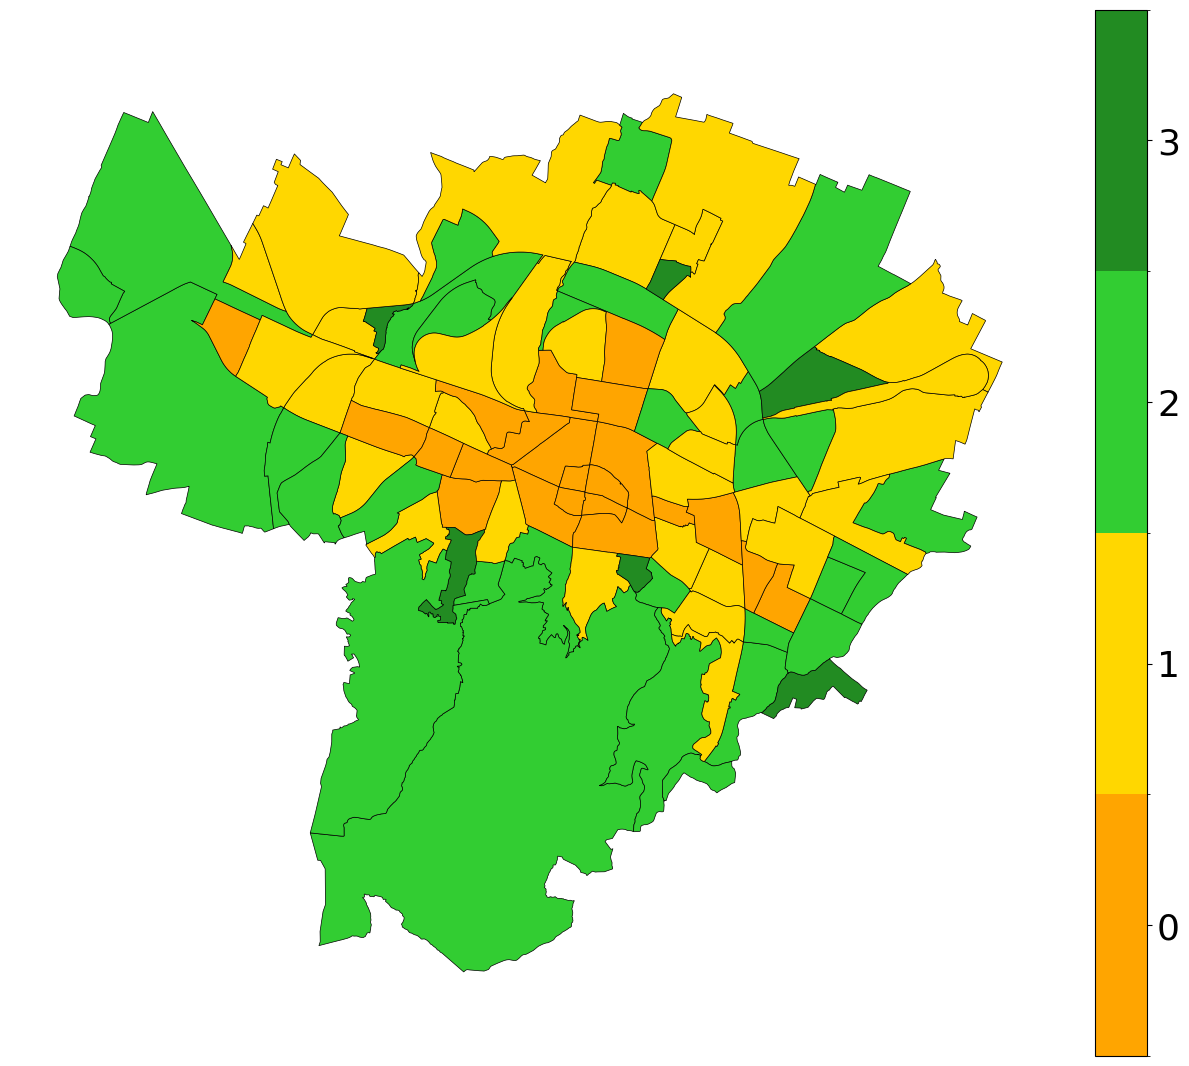

In [13]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mpl

cmap = ListedColormap(["orange", "gold", "limegreen", "forestgreen"])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]   # ogni intero cade in un intervallo
norm = BoundaryNorm(bounds, cmap.N)

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 12))
Bgds.plot(
    ax=ax,
    column="num_conditions_met",
    cmap=cmap,
    norm=norm,
    edgecolor="black",
    linewidth=0.5
)
ax.set_axis_off()
# Colorbar discreta con sole tacche intere
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(
    sm,
    ax=ax,
    ticks=[0, 1, 2, 3],
    fraction=0.046,   # larghezza relativa (più piccolo = più sottile)
    pad=0.04          # spazio tra mappa e barra
)
cbar.ax.set_yticklabels(["0", "1", "2", "3"])
cbar.ax.tick_params(labelsize=26)
#cbar.set_label("Condizioni superate (0–3)")

ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('quartieri_condizioni_superate.pdf', dpi=300, bbox_inches='tight')
plt.show()

# clustering

  File "C:\Users\eandreotti\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\eandreotti\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\eandreotti\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
 

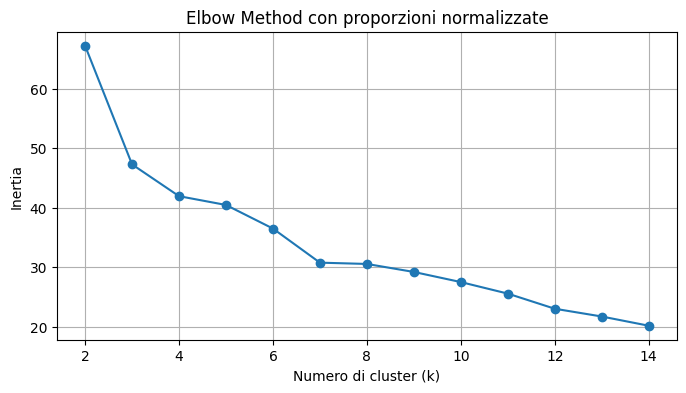

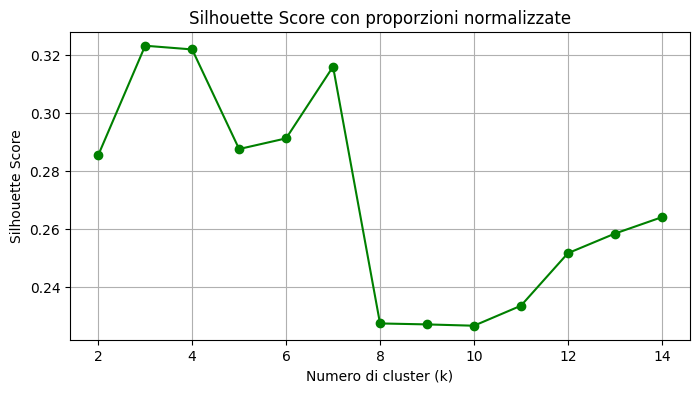

k=2: inertia=67.25, silhouette=0.285
k=3: inertia=47.28, silhouette=0.323
k=4: inertia=41.94, silhouette=0.322
k=5: inertia=40.46, silhouette=0.288
k=6: inertia=36.48, silhouette=0.291
k=7: inertia=30.75, silhouette=0.316
k=8: inertia=30.53, silhouette=0.227
k=9: inertia=29.18, silhouette=0.227
k=10: inertia=27.48, silhouette=0.227
k=11: inertia=25.54, silhouette=0.233
k=12: inertia=23.00, silhouette=0.252
k=13: inertia=21.69, silhouette=0.258
k=14: inertia=20.14, silhouette=0.264


In [15]:
# --- aggiungo gli indicatori 3-30-300 e condizioni soddisfatte
Bcounts_area=Bcounts_area[Bcounts_area['fsq_category_level1']!='Event']
Bcounts_area=Bcounts_area[['quartiere','codice_area_statistica','fsq_category_level1','count','residenti','area_km2',"nPOI/res", "nPOI/area", "nPOI/areares",'quartiere_area']]
chiavi = ['codice_area_statistica', 'codice_area_statistica']

chiave_bgds = next(k for k in chiavi if k in Bgds.columns)
chiave_bcount = next(k for k in chiavi if k in Bcounts_area.columns)

# 2) colonne da trasferire da Bgds
cols_da_aggiungere = [
     'meet_3',
     'meet_30',
     'meet_300',
    'num_conditions_met'
]

# tieni solo quelle effettivamente presenti
cols_presenti = [c for c in cols_da_aggiungere if c in Bgds.columns]

# 3) prepara un sotto-dataframe da unire
bgds_sub = Bgds[[chiave_bgds] + cols_presenti].copy()

# 4) unisci a sinistra su Bcount_area
Bcounts_area = Bcounts_area.merge(
    bgds_sub,
    left_on=chiave_bcount,
    right_on=chiave_bgds,
    how='left'
)

# 5) se i nomi chiave sono diversi, elimina la colonna-chiave "di destra"
if chiave_bcount != chiave_bgds:
    Bcounts_area.drop(columns=[chiave_bgds], inplace=True)
#----------------------------------------------------------------------------------------------------------
from sklearn.preprocessing import MinMaxScaler
categorie = Bcounts_area['fsq_category_level1'].unique()
Bdf_zona=Bcounts_area.copy()

#----------------------------
# numero di POIs per categoria normalizzate sull'area statsitica in modo tale da dare rilievo alle categorie piú presenti in ogni area statsistica. questa cosa non la cambierei
# numero di POIs totale per area statsitica. siccome perdiamo questa informazione, la aggiungiamo mediante variabile nPOI_areastat_norm
# questa variabile l'ho normalizzatat sul numero dei residenti dell'area statistuca, e poi la colonna viene normalizzata tra 0 e 1.


#----------------------------------------------
# Colonne da normalizzare -- queste sono possibili altre variabili che possono essere sostituite a values='count', tuttavia lascerei count.
columns_to_normalize = ["nPOI/res", "nPOI/area", "nPOI/areares",'num_conditions_met']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(Bdf_zona[columns_to_normalize])
for i, col in enumerate(columns_to_normalize):
    Bdf_zona[f"{col}"] = scaled[:, i] # se volessi rinominarle Bdf_zona[f"{col}_norm"] = scaled[:, i]
    
#Crea un nuovo DataFrame vuoto con le colonne per ogni categoria
for categoria in categorie:
    Bdf_zona[categoria] = Bdf_zona.apply(lambda row: 1 if row['fsq_category_level1'] == categoria else 0, axis=1)

# Rimuovi la colonna 'categoria' originale
Bdf_zona.drop(columns=['fsq_category_level1'], inplace=True)
Bdf_zona['categoria'] = Bdf_zona[categorie].idxmax(axis=1)
Bdf_zona = Bdf_zona.pivot_table(
    index=['codice_area_statistica', 'quartiere','residenti','num_conditions_met', 'meet_3','meet_30','meet_300'],
    columns='categoria',
    values='count',
    fill_value=0
).reset_index()
#----------------------- CREO LA COLONNA DEL NUMERO DI PUNTI PER AREA STATISTICA NORMALIZZATA
# Somma dei valori per riga
Bdf_zona["nPOI_areastat"] = Bdf_zona[categorie].sum(axis=1)
Bdf_zona["nPOI_areastat"] = Bdf_zona["nPOI_areastat"] / (Bdf_zona["residenti"])
# 2. Normalizzazione Min-Max della colonna "somma"
min_val = Bdf_zona["nPOI_areastat"].min()
max_val = Bdf_zona["nPOI_areastat"].max()


# Evita divisione per zero (se min = max)
denom = max_val - min_val if max_val - min_val != 0 else 1

Bdf_zona["nPOI_areastat_norm"] = (Bdf_zona["nPOI_areastat"] - min_val) / denom
#---------------------------------------
# Seleziona solo le colonne da normalizzare
cols = categorie

# Calcola min e max per riga
row_min = Bdf_zona[cols].min(axis=1)
row_max = Bdf_zona[cols].max(axis=1)

# Calcola il denominatore, evitando divisione per zero
denom = row_max - row_min
denom[denom == 0] = 1  # evita divisioni per 0

# Normalizza riga per riga
Bdf_zona[[f"{col}" for col in cols]] = (
    (Bdf_zona[cols].subtract(row_min, axis=0))
    .divide(denom, axis=0)
)
#-------------

#-------------------------

# Seleziona feature per clustering
#category_cols=categorie#+["nPOI_areastat_norm"]
category_cols = list(categorie) + [ 'meet_3','meet_30','meet_300']
feature_cols = [f'{col}' for col in category_cols]
BX = Bdf_zona[feature_cols]

# PCA
k_range = range(2, 15)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(BX)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(BX, labels))

# Plot Elbow
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method con proporzioni normalizzate')
plt.grid(True)
plt.show()

# Plot Silhouette
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score con proporzioni normalizzate')
plt.grid(True)
plt.show()

# Tabella riepilogativa
for k, inertia, sil in zip(k_range, inertias, silhouette_scores):
    print(f"k={k}: inertia={inertia:.2f}, silhouette={sil:.3f}")

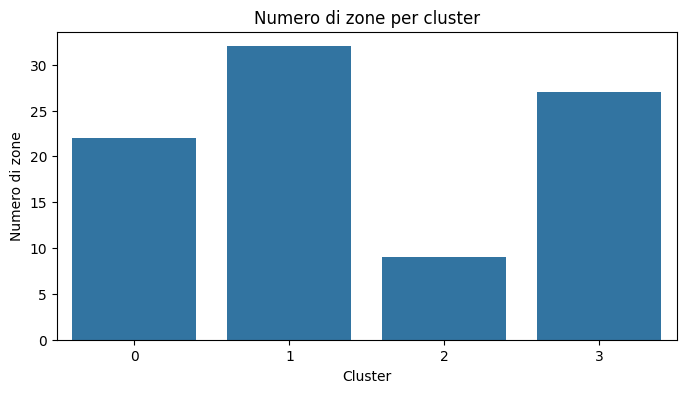

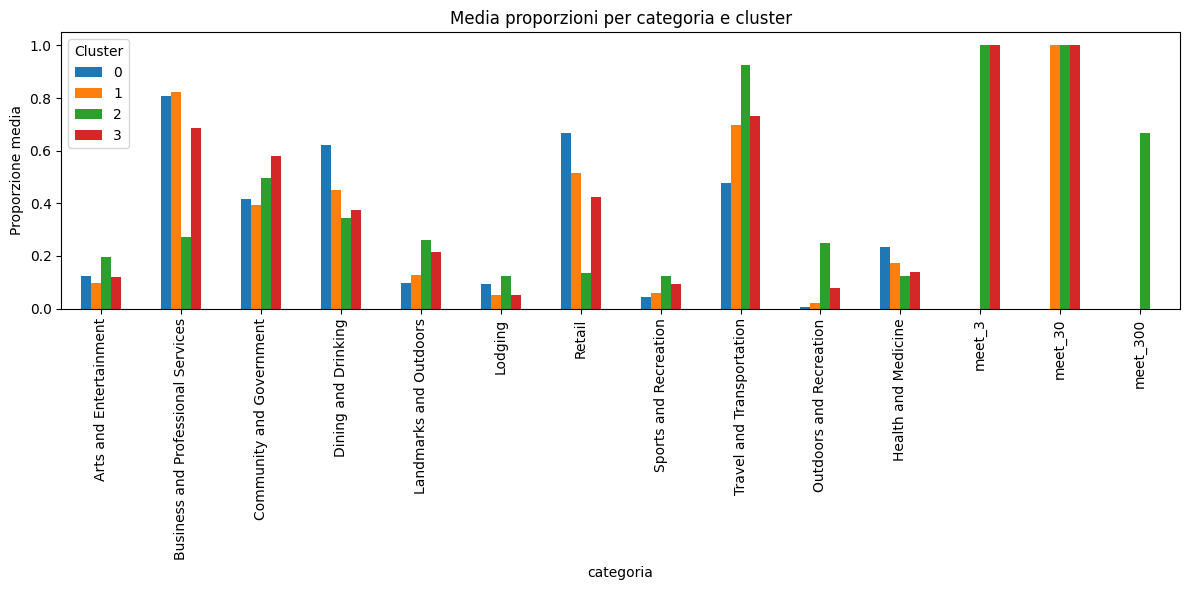

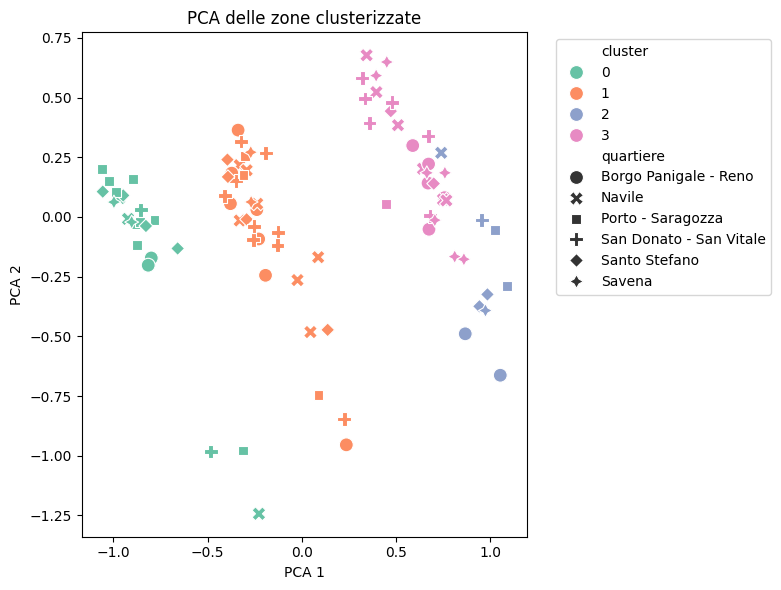


Tabella riepilogativa dei cluster assegnati e proporzioni per categoria:
categoria  codice_area_statistica              quartiere  cluster  \
0                             7.0  Borgo Panigale - Reno        0   
1                            15.0                 Navile        0   
2                            16.0                 Navile        0   
3                            17.0                 Navile        0   
4                            29.0      Porto - Saragozza        0   
..                            ...                    ...      ...   
85                           84.0                 Savena        3   
86                           85.0                 Savena        3   
87                           87.0                 Savena        3   
88                           89.0                 Savena        3   
89                           90.0                 Savena        3   

categoria  Arts and Entertainment  Business and Professional Services  \
0                       

categoria,codice_area_statistica,quartiere,cluster,Arts and Entertainment,Business and Professional Services,Community and Government,Dining and Drinking,Landmarks and Outdoors,Lodging,Retail,Sports and Recreation,Travel and Transportation,Outdoors and Recreation,Health and Medicine,meet_3,meet_30,meet_300
0,7.0,Borgo Panigale - Reno,0,0.074074,0.592593,0.407407,0.407407,0.074074,0.037037,1.000000,0.111111,0.555556,0.000000,0.185185,0,0,0
1,15.0,Navile,0,0.051282,1.000000,0.333333,0.705128,0.153846,0.115385,0.641026,0.076923,0.320513,0.000000,0.141026,0,0,0
2,16.0,Navile,0,0.015748,0.062992,0.055118,0.062992,0.047244,0.007874,0.031496,0.031496,1.000000,0.000000,0.031496,0,0,0
3,17.0,Navile,0,0.185714,0.971429,0.342857,1.000000,0.085714,0.157143,0.814286,0.000000,0.614286,0.014286,0.328571,0,0,0
4,29.0,Porto - Saragozza,0,0.152263,1.000000,0.333333,0.757202,0.065844,0.168724,0.707819,0.049383,0.633745,0.000000,0.160494,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,84.0,Savena,3,0.000000,0.318182,0.590909,0.181818,0.181818,0.000000,0.181818,0.045455,1.000000,0.045455,0.045455,1,1,0
86,85.0,Savena,3,0.031250,1.000000,0.718750,0.375000,0.093750,0.000000,0.625000,0.031250,0.562500,0.125000,0.312500,1,1,0
87,87.0,Savena,3,0.111111,0.666667,0.000000,0.444444,0.888889,0.000000,0.333333,0.000000,1.000000,0.333333,0.000000,1,1,0
88,89.0,Savena,3,0.023810,0.595238,0.642857,0.452381,0.119048,0.071429,0.404762,0.190476,1.000000,0.000000,0.071429,1,1,0


In [16]:
# Clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
Bdf_zona['cluster'] = kmeans.fit_predict(BX)

# Visualizza i cluster
plt.figure(figsize=(8,4))
sns.countplot(data=Bdf_zona, x='cluster')
plt.title('Numero di zone per cluster')
plt.xlabel('Cluster')
plt.ylabel('Numero di zone')
plt.show()

# Media delle proporzioni per cluster
cluster_means = Bdf_zona.groupby('cluster')[feature_cols].mean()
cluster_means.T.plot(kind='bar', figsize=(12,6))
plt.title('Media proporzioni per categoria e cluster')
plt.ylabel('Proporzione media')
plt.xticks(rotation=90)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# PCA per visualizzare
pca = PCA(n_components=2)
X_pca = pca.fit_transform(BX)
Bdf_zona['pca1'] = X_pca[:,0]
Bdf_zona['pca2'] = X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=Bdf_zona,
    x='pca1',
    y='pca2',
    hue='cluster',
    style='quartiere',
    palette='Set2',
    s=100
)
plt.title('PCA delle zone clusterizzate')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()
# Tabellina finale con tutte le informazioni
display_cols = ['codice_area_statistica', 'quartiere', 'cluster'] + list(feature_cols)

# Ordina per cluster e poi per zona
df_summary = Bdf_zona[display_cols].sort_values(['cluster', 'codice_area_statistica']).reset_index(drop=True)

print("\nTabella riepilogativa dei cluster assegnati e proporzioni per categoria:")
print(df_summary)

# Se preferisci visualizzare in un DataFrame ordinato
import pandas as pd
from IPython.display import display
display(df_summary)



# Analysis

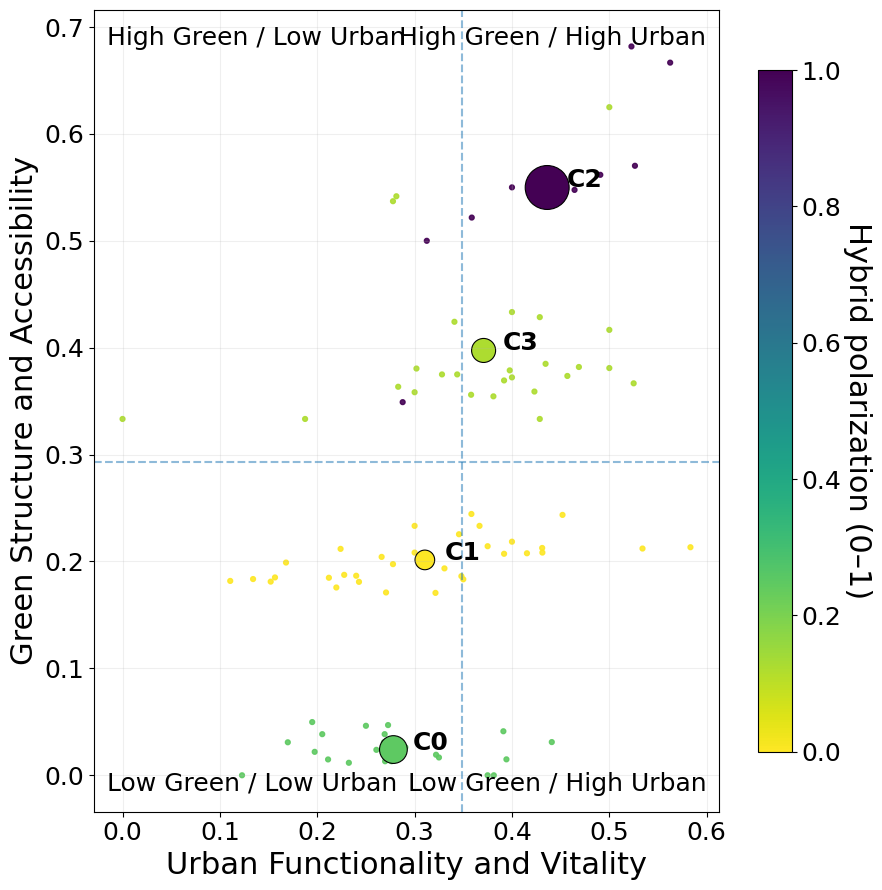


Cluster summary (indices + weighted entropy + internal CV + hybrid polarization):
         urban_index  green_index  entropy_weighted  cv_weighted  \
cluster                                                            
0              0.278        0.024             0.548        0.344   
1              0.311        0.201             0.627        0.300   
2              0.436        0.550             0.477        0.526   
3              0.371        0.397             0.577        0.318   

         polarization_hybrid  
cluster                       
0                      0.540  
1                      0.373  
2                      1.046  
3                      0.456  


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 1) Definizione feature
# =========================

# SOTTOINSIEME su cui misurare entropia/polarizzazione (come richiesto)
subset_feats = [
    'Arts and Entertainment',
    'Business and Professional Services',
    'Community and Government',
    'Dining and Drinking',
    'Retail',
    'Lodging',
    'Travel and Transportation',
    'Health and Medicine','Sports and Recreation','Outdoors and Recreation','Landmarks and Outdoors','num_conditions_met'
]

# Indici per gli assi del quadrante
urban_vars = [
    'Community and Government',
    'Travel and Transportation',
    'Lodging',
    'Arts and Entertainment'
]
green_vars = ['meet_3', 'meet_30', 'meet_300','Sports and Recreation','Outdoors and Recreation','Landmarks and Outdoors']
cols_needed = list(set(subset_feats + urban_vars + green_vars + ['cluster']))

# =========================
# 2) Controlli di base
# =========================
missing = [c for c in cols_needed if c not in Bdf_zona.columns]
if missing:
    raise ValueError(f"Mancano colonne in Bdf_zona: {missing}")

# =========================
# 3) Funzioni utili
# =========================
def shannon_entropy_normalized(x, eps=1e-12):
    """
    Entropia di Shannon normalizzata in [0,1] su un vettore non negativo.
    1 = profilo equilibrato; 0 = profilo totalmente dominato da una componente.
    """
    x = np.array(x, dtype=float)
    x = np.clip(x, 0, None)
    s = x.sum()
    if s <= eps:
        return 0.0
    p = x / s
    p = p[p > 0]
    H = -np.sum(p * np.log(p))
    Hmax = np.log(len(x))
    return float(H / Hmax)

# =========================
# 4) Statistiche per cluster
# =========================
# Medie per cluster (solo ciò che serve)
cluster_means = Bdf_zona.groupby('cluster')[list(set(subset_feats + urban_vars + green_vars))].mean()

# Varianza "between-cluster" per ciascuna feature del subset (importanza discriminativa)
between_var = cluster_means[subset_feats].var(axis=0)  # varianza tra cluster
eps = 1e-12
weights = (between_var + eps) / (between_var + eps).sum()  # pesi non-negativi, somma=1
w_scaled = weights * len(weights)  # media dei pesi = 1 (stabilizza la scala)

# ENTROPIA PESATA sui profili medi di cluster:
# idea: amplifico (o attenuo) le componenti prima di normalizzare, usando i pesi discriminativi
def weighted_entropy_on_subset(row_vals, w_scaled):
    x = np.array(row_vals, dtype=float)
    x = np.clip(x, 0, None)
    xw = x * w_scaled.values  # pesatura pre-normalizzazione
    return shannon_entropy_normalized(xw)

entropy_weighted = cluster_means[subset_feats].apply(lambda r: weighted_entropy_on_subset(r.values, w_scaled), axis=1)

# =========================
# 5) Variabilità interna (CV) pesata
# =========================
# Deviazione standard e media per cluster/variabile (sulle zone)
grp = Bdf_zona.groupby('cluster')[subset_feats]
means_in = grp.mean()
stds_in = grp.std(ddof=0)  # ddof=0 per coerenza con var "population-like"
cv_in = stds_in / (means_in.replace(0, np.nan))  # evita divisioni per 0
cv_in = cv_in.fillna(0.0)

# CV medio pesato sui pesi discriminativi (variabili più discriminanti contano di più)
cv_weighted = (cv_in * weights).sum(axis=1)

# =========================
# 6) Polarizzazione ibrida
# =========================
# Componenti:
#  - (1 - entropy_weighted): bassa entropia = profilo medio sbilanciato
#  - (1 + cv_weighted_norm): alta variabilità interna = più polarizzato
cv_norm = (cv_weighted - cv_weighted.min()) / (cv_weighted.max() - cv_weighted.min() + 1e-12)
polarization_hybrid = (1.0 - entropy_weighted) * (1.0 + cv_norm)

# Normalizza la metrica finale per plotting (0..1)
pol_min, pol_max = polarization_hybrid.min(), polarization_hybrid.max()
polarization_hybrid_norm = (polarization_hybrid - pol_min) / (pol_max - pol_min + 1e-12)

# =========================
# 7) Indici X/Y per il plot
# =========================
cluster_profile = pd.DataFrame(index=cluster_means.index)
cluster_profile['urban_index'] = cluster_means[urban_vars].mean(axis=1)
cluster_profile['green_index'] = cluster_means[green_vars].mean(axis=1)
cluster_profile['entropy_weighted'] = entropy_weighted
cluster_profile['cv_weighted'] = cv_weighted
cluster_profile['polarization_hybrid'] = polarization_hybrid
cluster_profile['polarization_hybrid_norm'] = polarization_hybrid_norm

# Num. elementi per cluster (per dimensione marker)
cluster_sizes = Bdf_zona.groupby('cluster').size()
#sizes = 100 + 10 * cluster_sizes.reindex(cluster_profile.index).values  # alternativa: usa entropia

# (Opzione alternativa) dimensione = entropia pesata (decommenta per usare questa)
sizes = 200 + 800 * cluster_profile['polarization_hybrid_norm'].values

# =========================
# 8) Overlay facoltativo delle singole zone
# =========================
zone_profile = pd.DataFrame(index=Bdf_zona.index)
zone_profile['urban_index'] = Bdf_zona[urban_vars].mean(axis=1)
zone_profile['green_index'] = Bdf_zona[green_vars].mean(axis=1)
zone_profile['cluster'] = Bdf_zona['cluster']

# =========================
# 9) Plot "Gartner-like" (color per cluster = funzione della polarizzazione)
# =========================
plt.figure(figsize=(9, 9))
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

# --- stessa cmap continua di prima, normalizzata su [0,1] ---
cmap = mpl.cm.get_cmap('viridis_r')
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

# colore di ciascun cluster = cmap(polarization_hybrid_norm del cluster)
cluster_color_map = {
    cl: cmap(norm(cluster_profile.loc[cl, 'polarization_hybrid_norm']))
    for cl in cluster_profile.index
}

# colori per i punti delle zone (prendono il colore del proprio cluster)
zone_colors = zone_profile['cluster'].map(cluster_color_map)

# Punti delle singole zone (trasparenti), colorati per cluster
plt.scatter(
    zone_profile['urban_index'],
    zone_profile['green_index'],
    s=12, alpha=0.9, marker='o',
    c=zone_colors
)

# Centroidi di cluster: stesso colore del cluster, dimensione = sizes
sc = plt.scatter(
    cluster_profile['urban_index'],
    cluster_profile['green_index'],
    c=[cluster_color_map[cl] for cl in cluster_profile.index],
    s=sizes,
    edgecolor='black',
    linewidth=0.8
)

# Linee di riferimento (medie tra cluster)
plt.axvline(cluster_profile['urban_index'].mean(), linestyle='--', alpha=0.5)
plt.axhline(cluster_profile['green_index'].mean(), linestyle='--', alpha=0.5)

# Etichette cluster
for cl, row in cluster_profile.iterrows():
    plt.text(row['urban_index'] + 0.02, row['green_index'], f'C{int(cl)}',
             fontsize=18, weight='bold')

plt.xlabel('Urban Functionality and Vitality', fontsize=22)
plt.ylabel('Green Structure and Accessibility', fontsize=22)

# Corner labels
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
pad_x = 0.02 * (x_max - x_min)
pad_y = 0.02 * (y_max - y_min)
plt.text(x_min + pad_x, y_max - pad_y, 'High Green / Low Urban',
         ha='left', va='top', fontsize=18)
plt.text(x_max - pad_x, y_max - pad_y, 'High Green / High Urban',
         ha='right', va='top', fontsize=18)
plt.text(x_min + pad_x, y_min + pad_y, 'Low Green / Low Urban',
         ha='left', va='bottom', fontsize=18)
plt.text(x_max - pad_x, y_min + pad_y, 'Low Green / High Urban',
         ha='right', va='bottom', fontsize=18)

plt.grid(alpha=0.2)

# --- colorbar che spiega la mappa polarizzazione → colore ---
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])  # necessario per creare la colorbar senza dati
# --- colorbar che spiega la mappa polarizzazione → colore ---
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([0, 1])  # piccolo array fittizio
ax = plt.gca()
cbar = plt.colorbar(mappable, ax=ax, shrink=0.85)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Hybrid polarization (0–1)', rotation=270, labelpad=22, fontsize=22)


plt.tight_layout()
plt.savefig('bologna_gardner_polarizzazione_cluster_colorbar.pdf', dpi=300, bbox_inches='tight')
plt.show()


# =========================
# 10) Tabella riassuntiva
# =========================
summary = cluster_profile[['urban_index','green_index','entropy_weighted','cv_weighted','polarization_hybrid']].copy()
summary = summary.sort_index()
print("\nCluster summary (indices + weighted entropy + internal CV + hybrid polarization):")
print(summary.round(3))


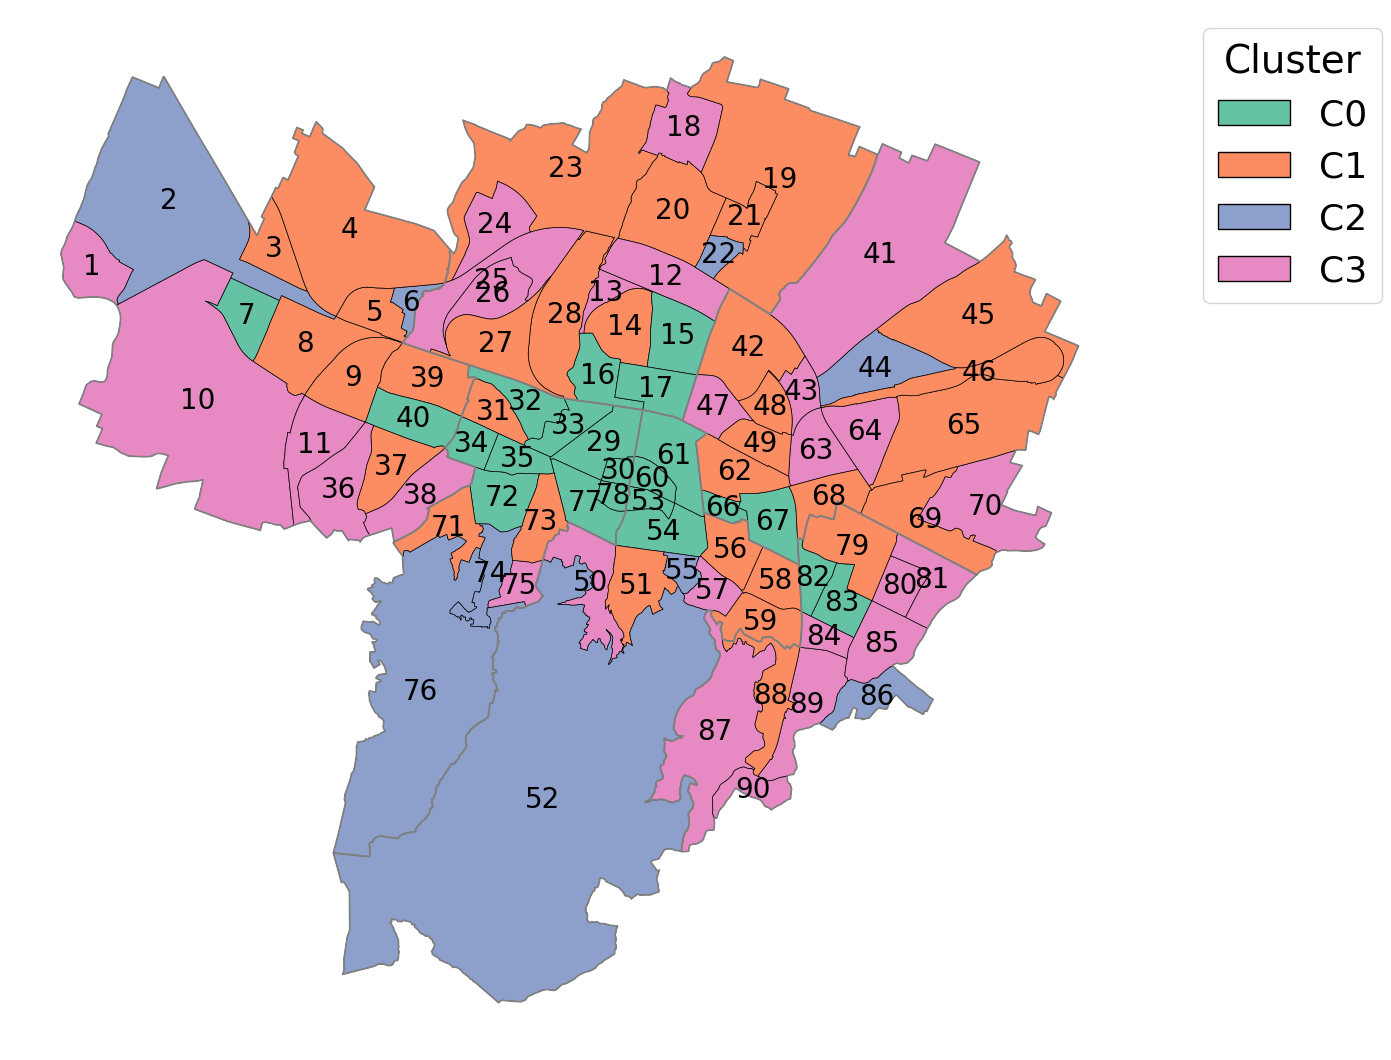

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import seaborn as sns
merged_gdf = Bgds.merge(df_summary[['codice_area_statistica', 'cluster']],
                       left_on='codice_area_statistica',
                       right_on='codice_area_statistica',
                       how='left')
# 5. Colori per i cluster
n_clusters = merged_gdf['cluster'].nunique()
cluster_palette = sns.color_palette("Set2", n_colors=n_clusters)
cluster_colors = {i: mcolors.to_hex(col) for i, col in enumerate(cluster_palette)}

# 6. Applica colori ai poligoni
merged_gdf['cluster_color'] = merged_gdf['cluster'].map(cluster_colors)

# 7. Plot della mappa
fig, ax = plt.subplots(figsize=(14,14))
merged_gdf.plot(ax=ax, color=merged_gdf['cluster_color'], edgecolor='black', linewidth=0.5)

# Disegna i bordi dei quartieri solo per riferimento (grigio scuro)
crs_usato = "EPSG:32632"

Bgdq = Bgdq.to_crs(crs_usato)
Bgdq.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=1.2)

# Aggiungi etichette dei codici area statistica
for idx, row in merged_gdf.iterrows():
    if row['geometry'].is_empty:
        continue
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y,
            str(row['codice_area_statistica']),
            fontsize=20, color='black', ha='center', va='center')

ax.axis('off')

# 8. Legenda dei cluster
legend_patches = [
    Patch(facecolor=color, edgecolor='black', label=f'C{cluster}')
    for cluster, color in cluster_colors.items()
]

ax.legend(handles=legend_patches,
          loc='upper left',
          bbox_to_anchor=(1.05,1),
          fontsize=26,
          title_fontsize=28,
          title='Cluster')

plt.tight_layout()
plt.savefig(f'bologna_clusters_map.pdf', dpi=300, bbox_inches='tight')
plt.show()


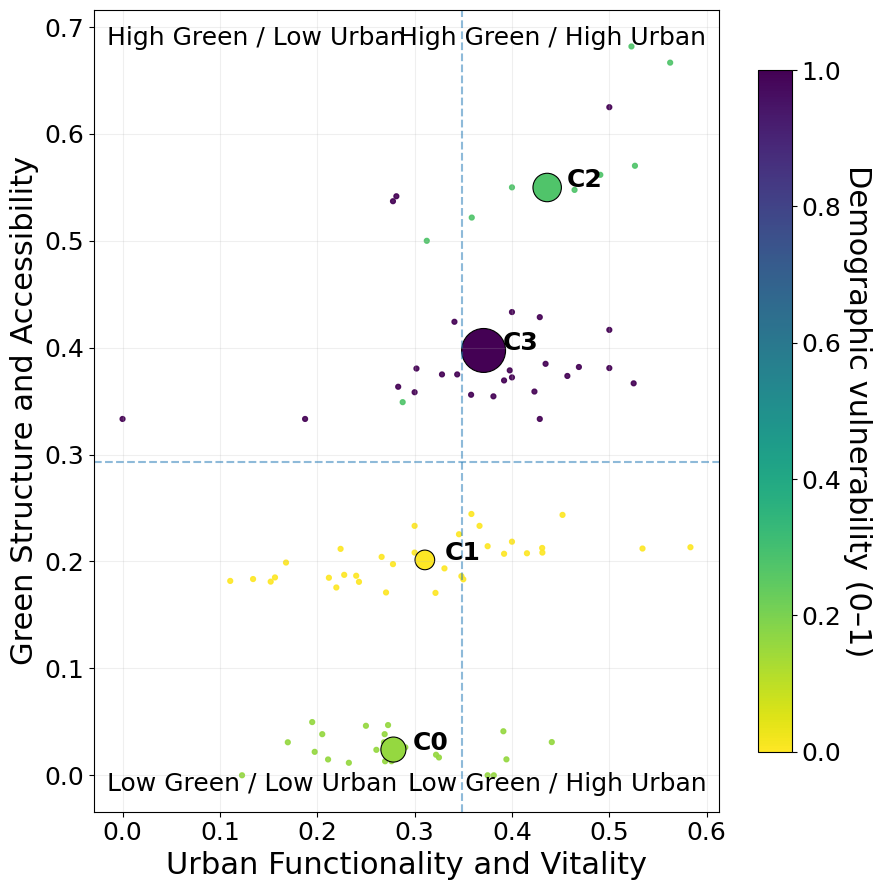

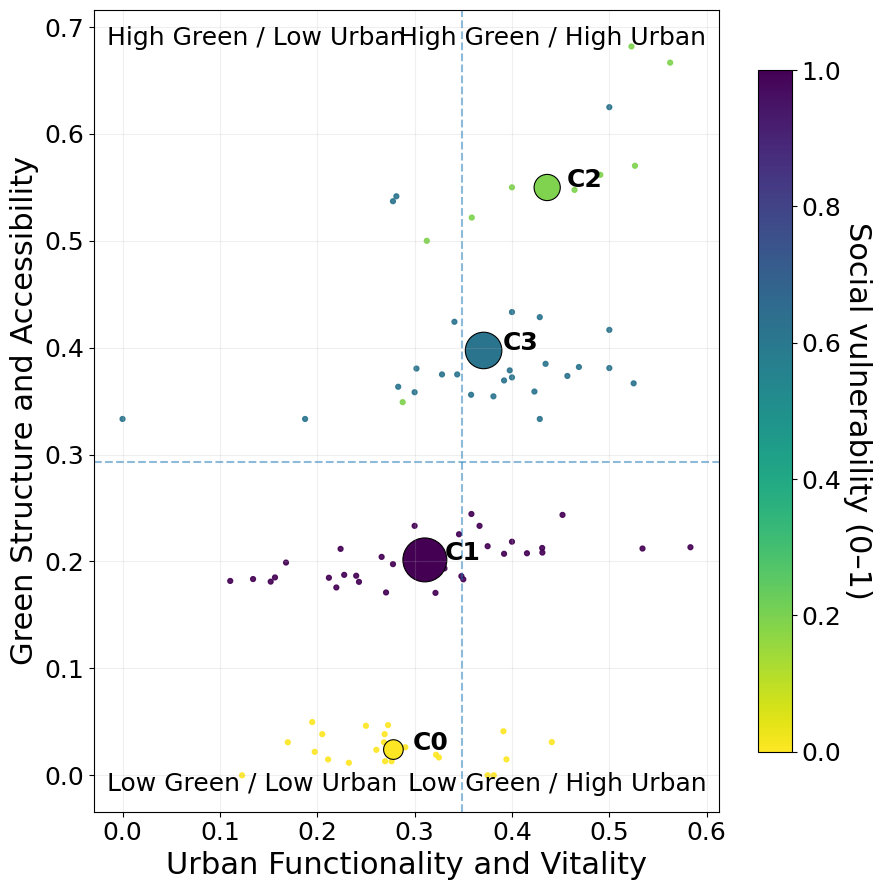

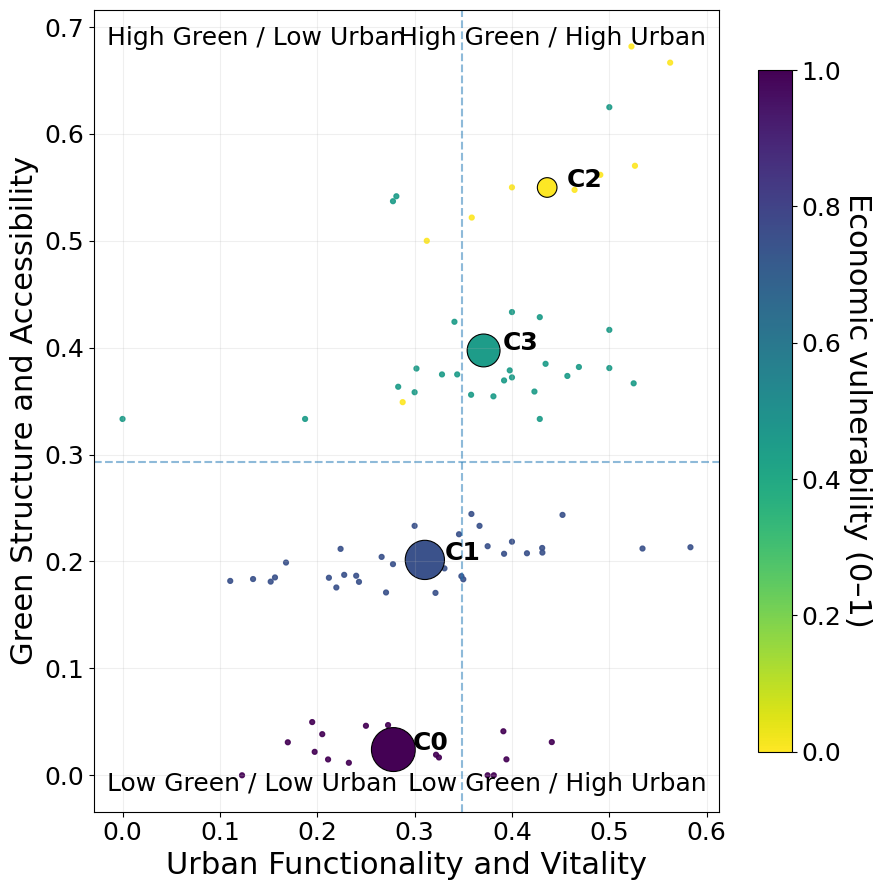

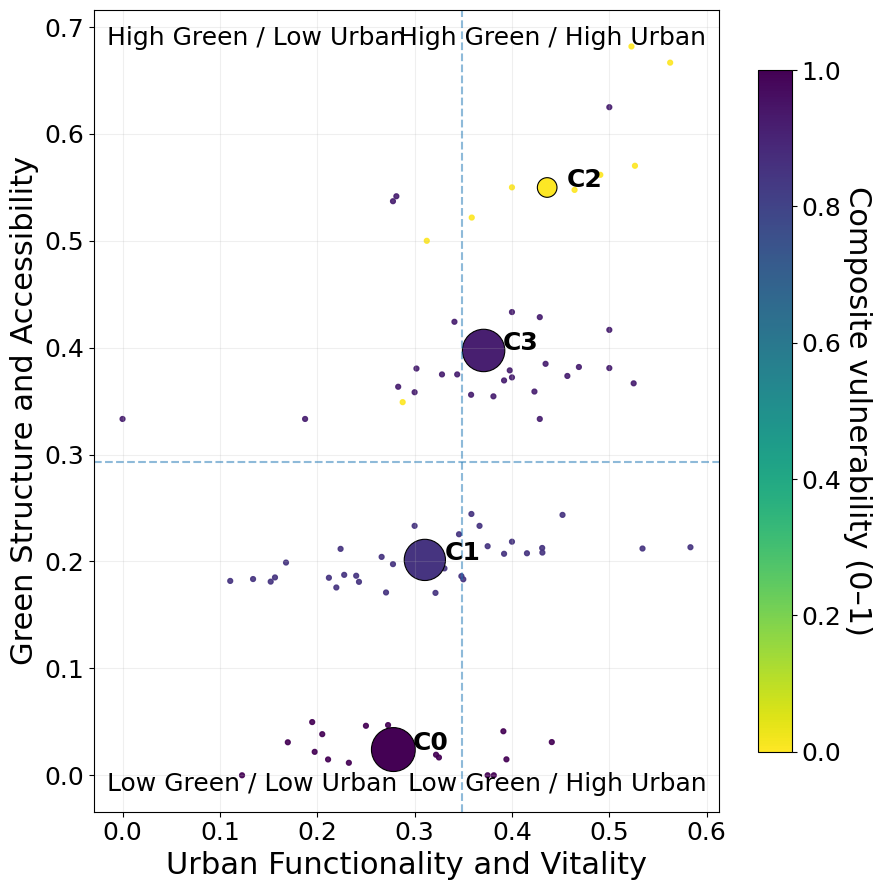

In [21]:
dfr_2023.rename(columns={'codareast': 'codice_area_statistica'}, inplace=True)
df_compare = merged_gdf.merge(
    dfr_2023[['codice_area_statistica', 'frag_demo', 'frag_soc', 'frag_econ', 'frag_compl']],
    on='codice_area_statistica',
    how='inner'
)

# --- 1) Prepara base con fragilità a livello di zona + cluster ---
frag_cols = ['frag_demo', 'frag_soc', 'frag_econ', 'frag_compl']
missing = [c for c in frag_cols if c not in df_compare.columns]
if missing:
    raise ValueError(f"Mancano colonne in df_compare: {missing}")

# Assumo che Bdf_zona abbia 'codice_area_statistica' e 'cluster'
base_df = Bdf_zona.merge(
    df_compare[['codice_area_statistica'] + frag_cols],
    on='codice_area_statistica',
    how='inner'
)


base_df[frag_cols] = base_df[frag_cols].fillna(
    base_df.groupby('cluster')[frag_cols].transform('mean')
)

# --- 2) Profili zona e cluster nello spazio (x=urban_index, y=green_index) ---
zone_profile_f = pd.DataFrame(index=base_df.index)
zone_profile_f['urban_index'] = base_df[urban_vars].mean(axis=1)
zone_profile_f['green_index'] = base_df[green_vars].mean(axis=1)
zone_profile_f['cluster'] = base_df['cluster']

cluster_means_space = base_df.groupby('cluster')[urban_vars + green_vars].mean()
cluster_profile_space = pd.DataFrame(index=cluster_means_space.index)
cluster_profile_space['urban_index'] = cluster_means_space[urban_vars].mean(axis=1)
cluster_profile_space['green_index'] = cluster_means_space[green_vars].mean(axis=1)

# --- 3) Fragilità medie per cluster + normalizzazione 0–1 per ciascuna metrica ---
cluster_frag = base_df.groupby('cluster')[frag_cols].mean()
cluster_frag_norm = cluster_frag.apply(
    lambda s: (s - s.min()) / (s.max() - s.min() + 1e-12),
    axis=0
)

# --- 4) Funzione di plotting riusabile per ogni fragilità ---
def plot_quadrant_for_frag(metric, pretty_label=None, cmap_name='viridis_r', save=True):
    if pretty_label is None:
        pretty_label = metric

    # Colori per cluster = cmap(fragilità_norm del cluster)
    cmap = mpl.cm.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
    frag_norm_series = cluster_frag_norm[metric]  # indice = cluster

    cluster_color_map = {cl: cmap(norm(frag_norm_series.loc[cl])) for cl in cluster_frag_norm.index}
    # Colori dei punti zona (dal cluster di appartenenza)
    zone_colors = zone_profile_f['cluster'].map(cluster_color_map)

    # Dimensione centroidi = funzione della fragilità del cluster
    sizes_f = 200 + 800 * frag_norm_series.reindex(cluster_profile_space.index).values

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(9, 9))
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18

    # Singole zone (trasparenti)
    ax.scatter(
        zone_profile_f['urban_index'],
        zone_profile_f['green_index'],
        s=12, alpha=0.9, marker='o',
        c=zone_colors
    )

    # Centroidi (colore=frag_norm del cluster, size = frag_norm)
    sc = ax.scatter(
        cluster_profile_space['urban_index'],
        cluster_profile_space['green_index'],
        c=[cluster_color_map[cl] for cl in cluster_profile_space.index],
        s=sizes_f,
        edgecolor='black',
        linewidth=0.8
    )

    # Linee di riferimento
    ax.axvline(cluster_profile_space['urban_index'].mean(), linestyle='--', alpha=0.5)
    ax.axhline(cluster_profile_space['green_index'].mean(), linestyle='--', alpha=0.5)

    # Etichette cluster
    for cl, row in cluster_profile_space.iterrows():
        ax.text(row['urban_index'] + 0.02, row['green_index'], f'C{int(cl)}',
                fontsize=18, weight='bold')

    ax.set_xlabel('Urban Functionality and Vitality', fontsize=22)
    ax.set_ylabel('Green Structure and Accessibility', fontsize=22)

    # Corner labels
    x_min, x_max = ax.get_xlim(); y_min, y_max = ax.get_ylim()
    pad_x = 0.02 * (x_max - x_min); pad_y = 0.02 * (y_max - y_min)
    ax.text(x_min + pad_x, y_max - pad_y, 'High Green / Low Urban',
            ha='left', va='top', fontsize=18)
    ax.text(x_max - pad_x, y_max - pad_y, 'High Green / High Urban',
            ha='right', va='top', fontsize=18)
    ax.text(x_min + pad_x, y_min + pad_y, 'Low Green / Low Urban',
            ha='left', va='bottom', fontsize=18)
    ax.text(x_max - pad_x, y_min + pad_y, 'Low Green / High Urban',
            ha='right', va='bottom', fontsize=18)

    ax.grid(alpha=0.2)

    # Colorbar (fragilità → colore)
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array([0, 1])  # array fittizio per la colorbar
    cbar = plt.colorbar(mappable, ax=ax, shrink=0.85)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(f'{pretty_label} (0–1)', rotation=270, labelpad=22, fontsize=22)

    plt.tight_layout()
    if save:
        plt.savefig(f"bologna_gartner_{metric}.pdf", dpi=300, bbox_inches='tight')
    plt.show()

# --- 5) Genera i 4 grafici (uno per fragilità) ---
label_map = {
    'frag_demo':  'Demographic vulnerability',
    'frag_soc':   'Social vulnerability',
    'frag_econ':  'Economic vulnerability',
    'frag_compl': 'Composite vulnerability',  # (aka Overall vulnerability)
}

for met in frag_cols:
    plot_quadrant_for_frag(met, pretty_label=label_map.get(met, met))
